# Directing Customers to Subscription Through App Behavior Analysis


In marketing analysis, the Machine Learning technics can provide a helpful tool. For example, companies that have mobile services in two version free and paid, want always to obtain the maximum number of subscription. One way to make the better publicities is to know the customers behavior, based on the behavior of each custumer some company can offer your mobile services.
But the question is: How can we know the custumers behavior ?
The answer for this question is simple, we construct a model of classification based on the client acitivities in the free services and then, we can classify if a certain custumer will subscripe or not.

# Importing Libraries

In [1]:
import pandas as pd
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Dataset

In [2]:
dataset = pd.read_csv('appdata10.csv')
dataset.shape


(50000, 12)

In [3]:
dataset.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                    object
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [4]:
dataset.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [5]:
dataset['hour'] = dataset.hour.str.slice(1,3).astype(int) # the values in the column hours are object variable we need to change it

In [6]:
dataset.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,23.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'first_open', 'enrolled', 'enrolled_date'])

In [8]:
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


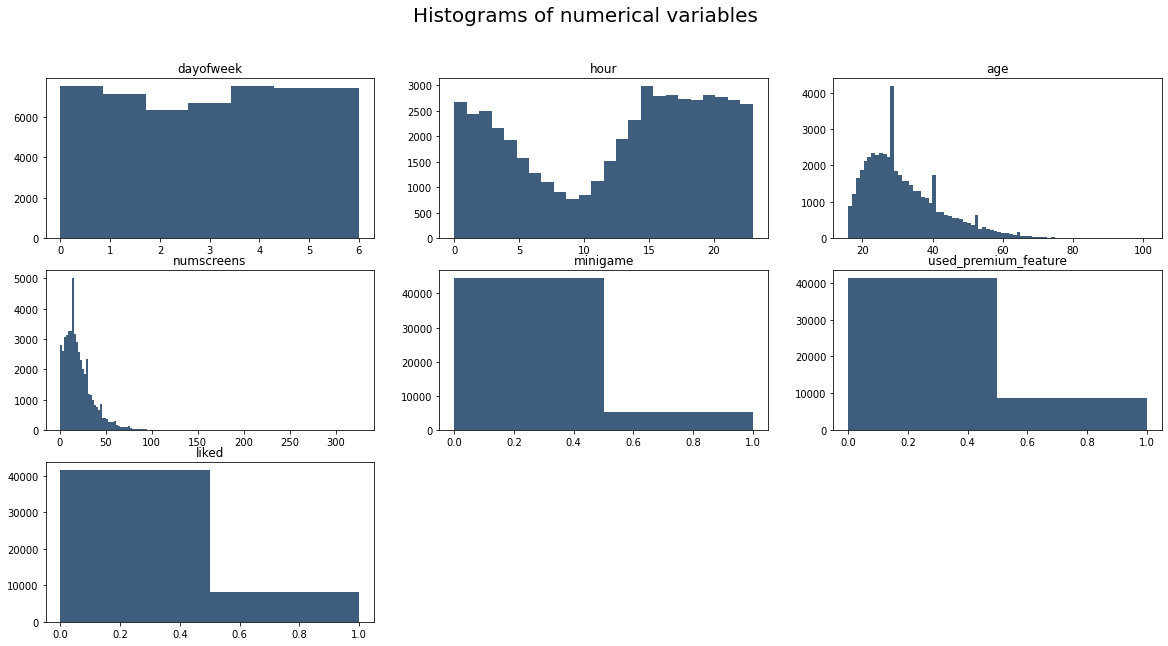

In [9]:
plt.figure(figsize=(20,10))
plt.suptitle('Histograms of numerical variables', fontsize = 20,)
for i in range(1, dataset2.shape[1] + 1):

  plt.subplot(3, 3, i)
  f = plt.gca()
  f.set_title(dataset2.columns.values[i-1])
  vals = np.size(dataset2.iloc[:, i-1].unique())
  plt.hist(dataset2.iloc[:, i-1], bins= vals, color = '#3F5D7D' )


## Correlation Plot

<AxesSubplot:title={'center':'Correlation with reponse variable'}>

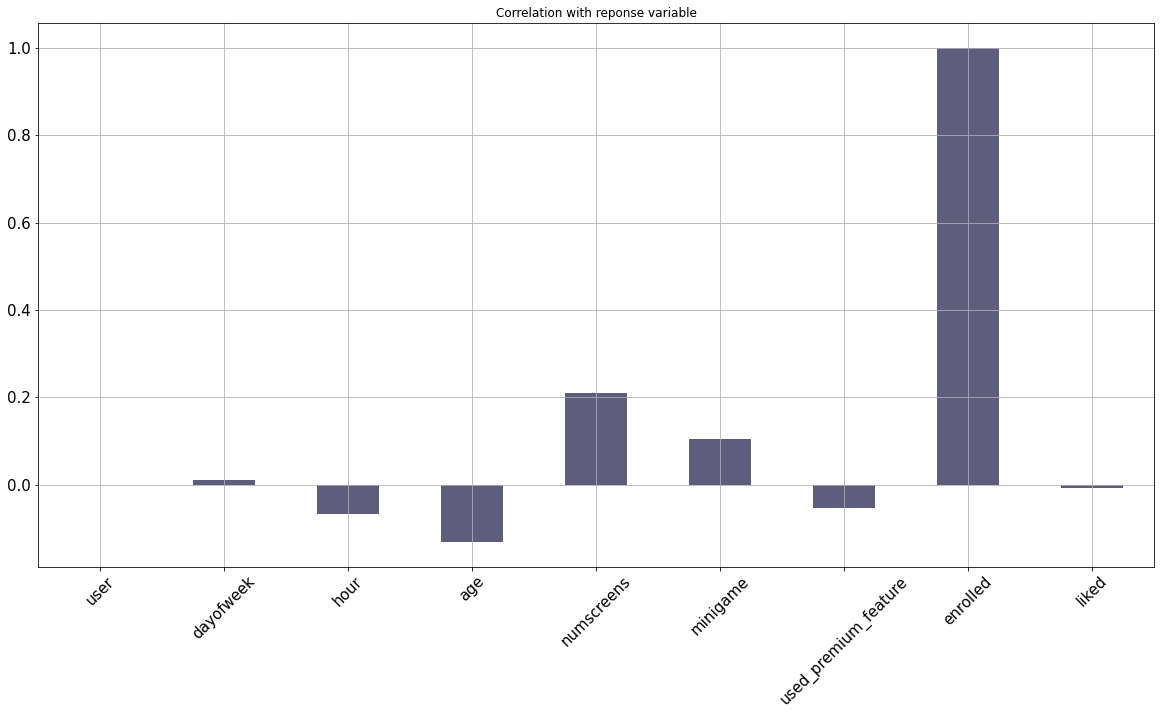

In [10]:
dataset.corrwith(dataset.enrolled).plot.bar(figsize = (20,10),
                                            title = 'Correlation with reponse variable',
                                            fontsize = 15, rot = 45, grid = True, color = '#5F5D7D')

## Correlation Matrix

<AxesSubplot:>

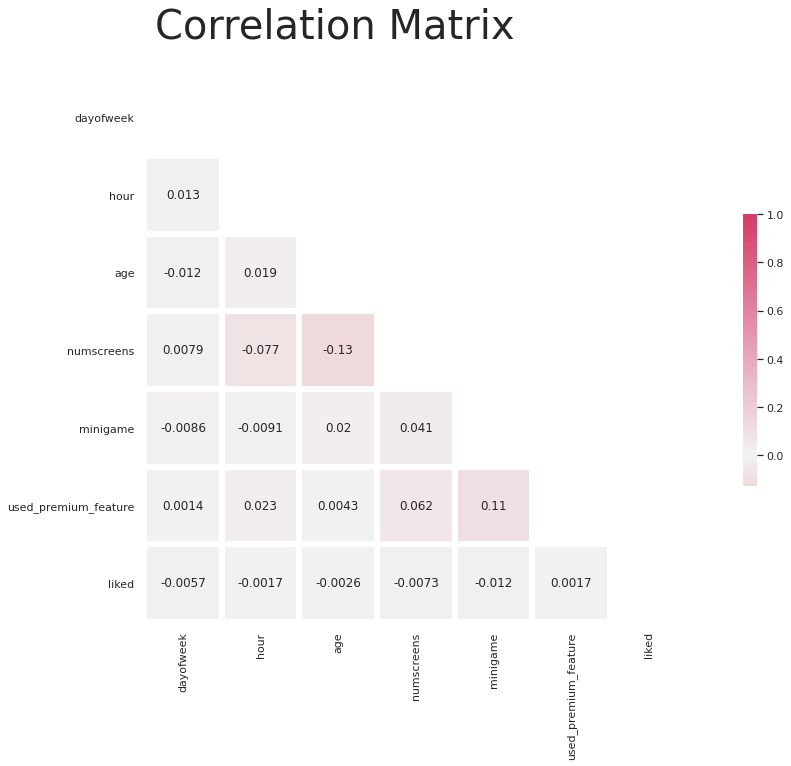

In [11]:
sns.set(style='white', font_scale= 1)
corr = dataset2.corr() # here we compute the correlation between numericals variables
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype= np.bool) # To generate a numpy array from correlation with true or false
mask[np.triu_indices_from(mask)] = True # To have the index of the upper triangle
# Setup the matplotlib figures
f, ax = plt.subplots(figsize = (20,10))
f.suptitle('Correlation Matrix', fontsize=40)
# Generate a custum diverging color map
cmap = sns.diverging_palette(10, 0, as_cmap=True)
# Draw the heatmap with the mask and the correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=1, center=0,
            square=True, linewidth=5, cbar_kws={'shrink': .5})

## Feature engineering - Response

In [12]:
dataset.dtypes
# The dates are objects, we need to change it. One reason is, we can calculate the difference between the first open and the enrolled date.
# This differece can be visualised in a distribution.

user                     int64
first_open              object
dayofweek                int64
hour                     int64
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

### Transforming the dates into numerical dates

In [13]:
dataset["first_open"] = [parser.parse(row_date) for row_date in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in dataset["enrolled_date"]]
dataset.dtypes

# Selecting Time For Response
dataset["difference"] = (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')

Text(0.5, 1.0, 'Distribution of Time-Since-Screan-Reached')

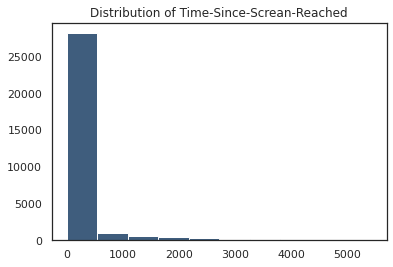

In [14]:
response_hist = plt.hist(dataset['difference'].dropna(), color= '#3F5D7D')
plt.title('Distribution of Time-Since-Screan-Reached')

Text(0.5, 1.0, 'Distribution of Time-Since-Screem-Reached')

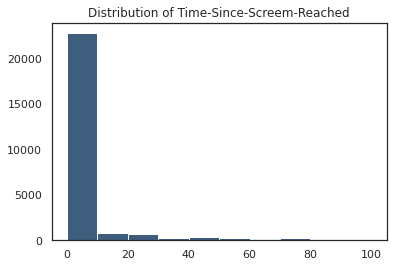

In [15]:
plt.hist(dataset['difference'].dropna(), color= '#3F5D7D', range = [0,100])
plt.title('Distribution of Time-Since-Screem-Reached')

As we can see in the above figure, we do not have a great number of inscription after 100 hours of application usage. In this case, to make the model more clear, we are going to change the response, all custumer that toke more then 48 hour to subscription will be turned into 0, it means, we do not consider them as a possible custumer.

### Changing the response based on Distribution of Time-Since-Screem-Reached

In [16]:
dataset.loc[dataset.difference > 48, 'enrolled'] = 0

In [17]:
# Now, one importante thing is to eliminate certains columns in our dataset. Due to the change on the response variable, the features first_open, date_enrolled and difference there are no more sense, for this reason we drop theese columns
dataset = dataset.drop(columns = ['difference', 'first_open', 'enrolled_date'])

## Feature engineering on the screen variables

In [18]:
# Loading the second csv file
top_screens = pd.read_csv('top_screens.csv').top_screens.values

In [19]:
# We need to change the separator of screen_list column
dataset['screen_list'] = dataset.screen_list.astype(str) +','

In [20]:
# Putting the top_screens as columns

for sc in top_screens:
  dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
  dataset['screen_list'] = dataset.screen_list.str.replace(sc+',','')


In [21]:
# We have more than 15 screens, so we need to count the others screens are not in the top_screens list

dataset['Other'] = dataset.screen_list.str.count(',')

In [22]:
# Now, we do not more need the screen_list

dataset = dataset.drop(columns=['screen_list'])

### Funnels

In [23]:
saving_screens = ['Saving1',
                  'Saving2',
                  'Saving2Amount',
                  'Saving4',
                  'Saving5',
                  'Saving6',
                  'Saving7',
                  'Saving8',
                  'Saving9',
                  'Saving10',]

In [24]:
dataset['TotalSaving'] = dataset[saving_screens].sum(axis = 1) # creating a new column

In [25]:
# Eliminating the saving_screens columns
dataset = dataset.drop(columns=saving_screens)

In [26]:
cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

In [27]:
cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

In [28]:
loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

In [29]:
dataset.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,TotalSaving,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


In [30]:
dataset.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,TotalSaving,CMCount,CCCount,LoansCount
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.497000,0.165000,0.517760,...,0.014220,0.013340,0.013400,0.008200,0.007580,6.214260,0.365020,0.92776,0.176860,0.788400
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.499996,0.371184,0.499689,...,0.118398,0.114727,0.114981,0.090183,0.086733,3.672561,1.405511,1.21751,0.612787,0.677462
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.00000,0.000000,1.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.00000,0.000000,1.000000
max,373662.000000,6.000000,23.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,10.000000,5.00000,3.000000,3.000000


In [31]:
dataset.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'location', 'Institutions',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth', 'ProfilePage',
       'VerifyCountry', 'Cycle', 'idscreen', 'Splash', 'RewardsContainer',
       'EditProfile', 'Finances', 'Alerts', 'Leaderboard', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'ResendToken',
       'TransactionList', 'NetworkFailure', 'ListPicker', 'Other',
       'TotalSaving', 'CMCount', 'CCCount', 'LoansCount'],
      dtype='object')

###Saving the dataset

In [32]:
dataset.to_csv('new_appdata10.csv', index = False)